In [2]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

In [3]:
#convert saved BELLA quad scan data into correct format for subsequent analysis
from PIL import Image, ImageOps
import re

# Function to pad the images to be square
def pad_to_square(img):
    width, height = img.size
    new_size = max(width, height)
    delta_w = new_size - width
    delta_h = new_size - height
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(img, padding)

# Function to get all image files from a specified directory
def get_image_files(dir_path):
    # Get a list of all files with the specified extensions
    files = [f for f in os.listdir(dir_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Extract the number from each filename and sort the files based on these numbers
    sorted_files = sorted(files, key=lambda x: int(re.search(r'_(\d+)', x).group(1)))
    
    return sorted_files

# Get a list of all image files in the specified directory
image_folder_path = "16bit_images/"
image_files = get_image_files(image_folder_path)

# Open, pad to make square, and resize each image, then convert them to grayscale
image_list = []
for file in image_files:
    img = Image.open(os.path.join(image_folder_path, file))
    img = pad_to_square(img)
    
    # Get the new dimensions after padding
    width, height = img.size
    
    # Crop 200 pixels from each edge
    img = img.crop((200, 200, width - 200, height - 200))
    
    img = img.resize((200, 200))
    
    # Convert the image to a numpy array
    img_array = np.array(img, dtype=np.float32)
    
    # Find the maximum value in the image
    max_value = np.amax(img_array)
    
    # Normalize the image by dividing each pixel by the maximum value
    img_array /= max_value
    image_list.append(np.array(img, dtype=np.float32))

# Convert the images to a torch tensor
images_tensor = torch.stack([torch.tensor(np.array(img)) for img in image_list])

# Add an extra dimension for the channel (grayscale)
images_tensor = images_tensor.unsqueeze(1)

images=images_tensor.double()



# convert quad current values to normalized k values
def EMQ3CurToGrad(cur):
    return 2.9016 * cur + 0.093

def gradientToK(gradient,energy):
    return gradient*299.8/energy

currents=np.linspace(1.3,2.3,11)
gradients = EMQ3CurToGrad(currents)

# Fixed value of energy
energy = 105

# # Convert the gradients tensor to a numpy array for easier manipulation
# gradients_numpy = gradients.numpy()

# Apply the function to each gradient value
k_values_numpy = gradientToK(gradients, energy)

# Convert the k_values back to a torch tensor
k_values_tensor = torch.tensor(k_values_numpy).unsqueeze(1).unsqueeze(2).double()

# k_values_tensor = k_values_tensor.unsqueeze(1).unsqueeze(2)
ks=k_values_tensor

In [4]:
from phase_space_reconstruction.modeling import ImageDataset, ImageDataset3D

# create image dataset
save_as='test.dset'
dset = ImageDataset(ks[1::2], images[::2])

# save scan data if wanted
if save_as is not None:
    # Include the path to the "data" directory in the save_as variable
    save_as = os.path.join("data", save_as)
    
    # Check if the "data" directory exists, if not, create it
    if not os.path.exists("data"):
        os.makedirs("data")
    
    # Save the dataset in the "data" directory
    torch.save(dset, save_as)
    print(f"dataset saved as '{save_as}'")
    
    
# create image dataset
save_as='train.dset'
dset = ImageDataset(ks[::2], images[::2])

# save scan data if wanted
if save_as is not None:
    # Include the path to the "data" directory in the save_as variable
    save_as = os.path.join("data", save_as)
    
    # Check if the "data" directory exists, if not, create it
    if not os.path.exists("data"):
        os.makedirs("data")
    
    # Save the dataset in the "data" directory
    torch.save(dset, save_as)
    print(f"dataset saved as '{save_as}'")

dataset saved as 'data/test.dset'
dataset saved as 'data/train.dset'


In [5]:
data_dir = 'data'

In [6]:
# load data:
train_dset = torch.load(os.path.join(data_dir,'train.dset'))
test_dset = torch.load(os.path.join(data_dir,'test.dset'))

# image bins: 
bins_x = torch.linspace(-7.32, 7.32, train_dset.images.shape[-2])*1e-3
bins_y = torch.linspace(-7.32, 7.32, train_dset.images.shape[-1])*1e-3

image size = 15 x 15 mm
test samples boxed in orange


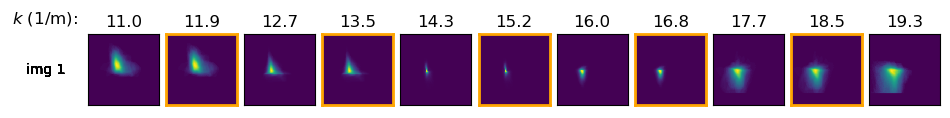

In [7]:
fig, ax = plot_scan_data(train_dset, test_dset, bins_x, bins_y)
plt.show()

In [8]:
# diagnostic beamline:
lattice = quad_drift(l_d=2.126, l_q=0.1409)

# design momentum (eV)
p0c = energy* 1e6

# diagnostic screen: 
bandwidth = (bins_x[1]-bins_x[0]) / 2
screen = ImageDiagnostic(bins_x, bins_y, bandwidth)

In [30]:
# training
pred_beam = train_1d_scan(train_dset, lattice, p0c, screen, n_epochs=50)

Using device: cpu
0 tensor(4877271.8332, dtype=torch.float64, grad_fn=<MulBackward0>)


In [31]:
# predicted screens:
ks = torch.vstack((train_dset.k, test_dset.k))
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 15 x 15 mm
test samples boxed in orange


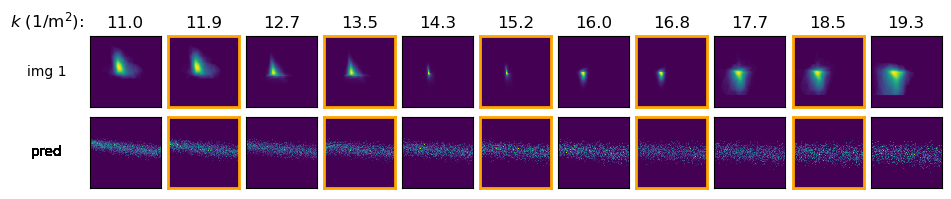

In [32]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins_x, bins_y)
plt.show()

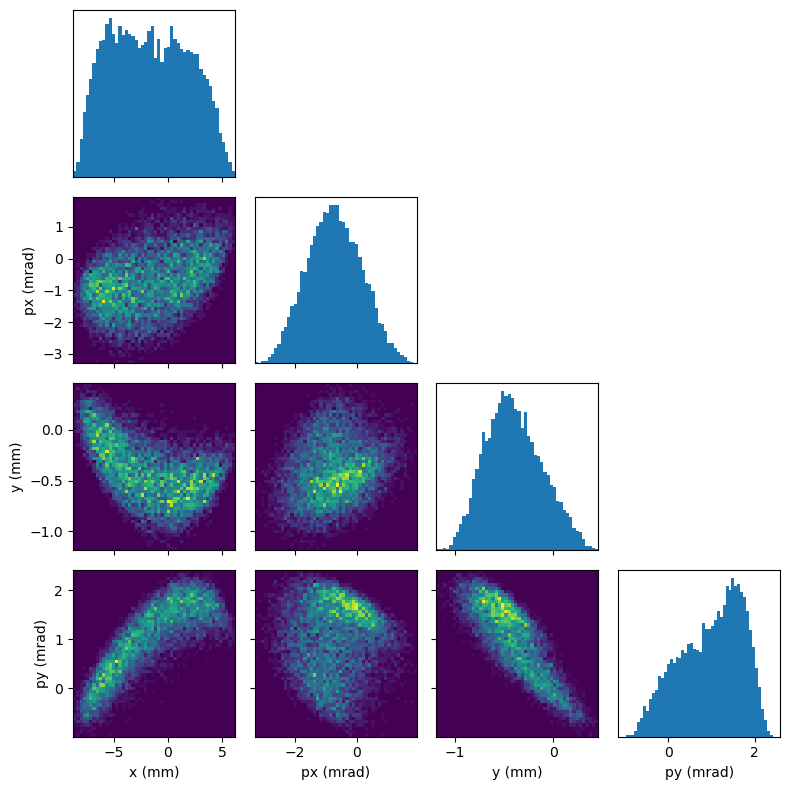

In [34]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=['x', 'px', 'y', 'py'],
                           bins=50,
                           background=False
                           )
plt.show()

In [35]:
emity=np.sqrt(np.mean(pred_beam.py.numpy()**2)*np.mean(pred_beam.y.numpy()**2)-(np.mean(pred_beam.y.numpy()*pred_beam.py.numpy()))**2)
betay=np.std(pred_beam.y.numpy())**2/(emity)

emitx=np.sqrt(np.mean(pred_beam.px.numpy()**2)*np.mean(pred_beam.x.numpy()**2)-(np.mean(pred_beam.x.numpy()*pred_beam.px.numpy()))**2)
betax=np.std(pred_beam.x.numpy())**2/(emitx)
print(betax,betay)
print(emitx,emity)

3.399992941302108 0.4117627812876182
3.696679916559973e-06 1.9758300770128108e-07


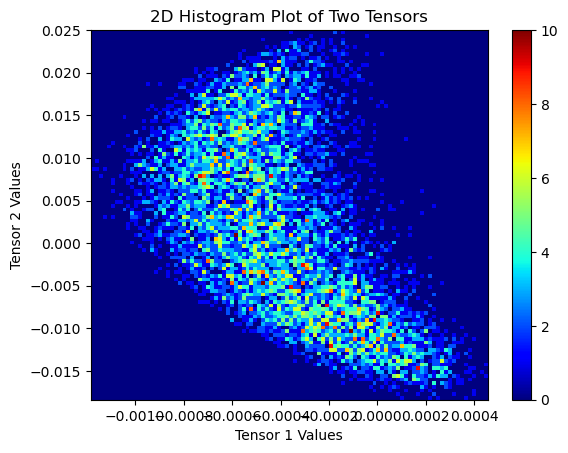

In [36]:
import matplotlib.pyplot as plt

# Assuming tensor1 and tensor2 are your tensors (replace with your actual tensors)
tensor1 = pred_beam.y
tensor2 = pred_beam.pz

# Convert tensors to numpy arrays for plotting
array1 = tensor1.numpy()
array2 = tensor2.numpy()

# Create a 2D histogram plot
plt.hist2d(array1, array2, bins=(100, 100), cmap=plt.cm.jet)

# Set labels and title (optional)
plt.xlabel('Tensor 1 Values')
plt.ylabel('Tensor 2 Values')
plt.title('2D Histogram Plot of Two Tensors')

# Add a colorbar to show the color mapping
plt.colorbar()

# Display the plot
plt.show()

In [37]:
import os
os.environ["PATH"] += os.pathsep + '/Users/samuelbarber/science_code/sdds_tools'
os.environ["PATH"] += os.pathsep + '/Users/samuelbarber/science_code/elegant'

def extract_and_map_data(pred_beam):
    c = 299792458  # Speed of light in meters per second
    
    # Define the mapping
    mapping = {
        'x': 'x',
        'px': 'xp',
        'y': 'y',
        'py': 'yp',
        'z': 't',
        'pz': 'p'
    }

    # Extract and map data
    data = []
    for key, new_key in mapping.items():
        values = getattr(pred_beam, key).numpy()  # Convert tensor to numpy array
        if new_key == 't':
            values /= c
        data.append(values)

    return np.column_stack(data)

def save_to_csv(data, filename="data.csv"):
    header = ",".join(['x', 'xp', 'y', 'yp', 't', 'p'])  # Define the column names for the CSV
    np.savetxt(filename, data, delimiter=",", header=header, comments="")

    
# Extract and map data
data = extract_and_map_data(pred_beam)

# Save the data to CSV
save_to_csv(data)

# Convert the CSV to SDDS using the command line (you'll do this outside the Python script)
!csv2sdds data.csv -columnData=name=x,type=double -columnData=name=xp,type=double -columnData=name=y,type=double -columnData=name=yp,type=double -columnData=name=t,type=double -columnData=name=p,type=double output.sdds